In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from torch.autograd import Variable
import torchvision

In [ ]:
class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.ngf = 64
        self.define_module()

    def define_module(self):
        ngf = self.ngf
        in_dim = 64
        self.fc = nn.Sequential(
            nn.Linear(in_dim, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True))

        self.upsample1 = upBlock(ngf, ngf // 2)
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        self.to_rgb = TO_RGB_LAYER(ngf // 4)

    def forward(self, z_code):
        out_code = self.fc(z_code)
        out_code = out_code.view(-1, self.ngf, 4, 4)  # 64 * 4 * 4
        out_code = self.upsample1(out_code)              # 32 * 8 * 8
        out_code = self.upsample2(out_code)              # 16 * 16 * 16
        img = self.to_rgb(out_code)
        return img
    

class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.define_module()

    def define_module(self):
        ndf = 16
        self.from_rgb = fromRGB_layer(ndf)
        self.downblock1 = downBlock_p(ndf, ndf * 2, 3, 1, 1)
        self.downblock2 = downBlock_p(ndf * 2, ndf * 4, 3, 1, 1)
#         self.downblock3 = downBlock_p(ndf * 2, ndf * 2, 3, 1, 1)
        self.uncond_logits = PartialConv(ndf * 4, 1, kernel_size=4, stride=4)
    def forward(self, x_var, mask=None):
        """
        - x_var (tensor): 3x16x16
        - mask (tensor): 1x16x16
        """
        x_code = self.from_rgb(x_var)                 # 16 * 16 * 16
        x_code, mask = self.downblock1(x_code, mask)  # 32 * 8 * 8
        x_code, mask = self.downblock2(x_code, mask)  # 64 * 4 * 4

        rf_score, _ = self.uncond_logits(x_code, mask)
        rf_score = F.sigmoid(rf_score)
        return rf_score.view(-1)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d):
        nn.init.orthogonal(m.weight.data, 1.0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.Linear):
        nn.init.orthogonal(m.weight.data, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
    elif classname == 'PartialConv':
        nn.init.constant_(m.mask_conv.weight.data, 1.0)

        
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_planes),
        nn.LeakyReLU(0.2, inplace=True))
    return block


class TO_RGB_LAYER(nn.Module):
    def __init__(self, ngf):
        super().__init__()
        self.gf_dim = ngf
        self.img = nn.Sequential(
            nn.Conv2d(ngf, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, h_code):
        out_img = self.img(h_code)
        return out_img

    
class PartialConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, 
                 dilation=1, groups=1,bias=False):
        super().__init__()
        self.input_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv2d(
            1, 1, kernel_size, stride, padding, dilation, groups, False)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

        self.bias = self.input_conv.bias

    def forward(self, input, mask):
        """
        input is regular tensor with shape N*C*H*W
        mask has to have 1 channel N*1*H*W

        mask: 0's for foreground
        """
        if mask is None:
            return self.input_conv(input), mask
        
        output = self.input_conv(input * mask)
        # get bias which will be used later
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            _frac = self.mask_conv(torch.ones_like(mask))
            mask = self.mask_conv(mask)

        no_update_holes = mask == 0
        mask_ratio = _frac / mask.masked_fill_(no_update_holes, 1.0)
        output_pre = (output - output_bias) * mask_ratio + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)
        new_mask = 1 - no_update_holes.float()
        return output, mask


class downBlock_p(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, 
                 dilation=1, groups=1, bias=False):
        super().__init__()
        self.conv = PartialConv(in_channels, out_channels,
            kernel_size, stride, padding, dilation, groups, bias)
        # self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, input, mask=None):
        """
        input is regular tensor with shape N*C*H*W
        mask has to have 1 channel N*1*H*W
        """
        output, mask = self.conv(input, mask)
        # output = self.bn(output)
        output = F.leaky_relu(output, 0.2, inplace=True)
        output = F.avg_pool2d(output, 2)
        if mask is not None:
            mask = F.avg_pool2d(mask, 2)
            no_update_holes = mask == 0
            mask = 1 - no_update_holes.float()
        return output, mask
    
    
def fromRGB_layer(out_planes):
    layer = nn.Sequential(
        nn.Conv2d(3, out_planes, 1, 1, 0, bias=False),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return layer

In [ ]:
norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def get_mask(imshape, bbox):
    """
    mask: 0's for foreground
    """
    c, r = imshape
    x1, y1, w, h = bbox
    x2 = x1 + w
    y2 = y1 + h
    mk = np.ones((r, c))
    mk[y1: y2 + 1, x1: x2 + 1] = 0
    return Image.fromarray(mk)

def train_img_gen():
    imsize = 16
    img = 255 * np.concatenate((np.ones((imsize,imsize,1)), np.zeros((imsize,imsize,2))), axis=2).astype(np.uint8)
    bbox = np.random.randint(0,imsize+1,4)
    x1 = np.min(bbox[0:2])
    x2 = np.max(bbox[0:2])
    y1 = np.min(bbox[2:4])
    y2 = np.max(bbox[2:4])
    img[y1: y2 + 1, x1: x2 + 1, 0] = 0
    img[y1: y2 + 1, x1: x2 + 1, 1] = 255
#     print(x1,y1,x2,y2)
    img = Image.fromarray(img)
    mk = torch.ones((1, imsize, imsize))
    mk[0, y1: y2 + 1, x1: x2 + 1] = 0
#     plt.hold()
#     plt.imshow(img)
#     plt.imshow(mk)
    return norm(img), mk

In [ ]:
def imshow(im):
    _im = torchvision.utils.make_grid(im, pad_value=-1).detach().numpy()
    _im = np.transpose(_im, (1, 2, 0))
    _im = (_im + 1) * 255 / 2
    _im = _im.astype(np.uint8)
    plt.imshow(_im)

In [ ]:
def prepare_data(batch_size):
    imsize = 16
    im_li = []
    mk_li = []
    for i in range(batch_size):
        im, mk = train_img_gen()
        im = im.view(1, 3, imsize, imsize)
        mk = mk.view(1, 1, imsize, imsize)
        im_li.append(im)
        mk_li.append(mk)
    ims = torch.cat(im_li, dim=0)    
    mks = torch.cat(mk_li, dim=0) 
    return ims, mks

In [ ]:
max_count = 20001
batch_size = 16
nz = 64

In [ ]:
netG = G()
netD = D()
netG.apply(weights_init)
netD.apply(weights_init)
optD = optim.Adam(netD.parameters(),
                  lr=2e-4,
                  betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(),
                  lr=2e-4,
                  betas=(0.5, 0.999))
criterion_one = nn.BCELoss()

/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  if __name__ == '__main__':
/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  after removing the cwd from sys.path.


[1/20]Loss_D: 0.97 Loss_G: 0.72 Time: 35.98s
[2/20]Loss_D: 0.66 Loss_G: 1.13 Time: 35.96s
[3/20]Loss_D: 0.74 Loss_G: 0.96 Time: 35.87s
[4/20]Loss_D: 0.65 Loss_G: 0.94 Time: 37.47s
[5/20]Loss_D: 0.64 Loss_G: 1.15 Time: 37.72s
[6/20]Loss_D: 0.52 Loss_G: 0.99 Time: 39.36s
[7/20]Loss_D: 0.68 Loss_G: 0.98 Time: 37.55s
[8/20]Loss_D: 0.55 Loss_G: 1.96 Time: 36.99s
[9/20]Loss_D: 0.61 Loss_G: 1.16 Time: 36.99s
[10/20]Loss_D: 0.59 Loss_G: 1.24 Time: 40.11s
[11/20]Loss_D: 0.43 Loss_G: 1.90 Time: 40.99s
[12/20]Loss_D: 0.58 Loss_G: 1.24 Time: 36.63s
[13/20]Loss_D: 0.56 Loss_G: 0.91 Time: 37.27s
[14/20]Loss_D: 0.62 Loss_G: 1.18 Time: 38.30s
[15/20]Loss_D: 0.59 Loss_G: 1.30 Time: 40.34s
[16/20]Loss_D: 0.67 Loss_G: 0.86 Time: 36.45s
[17/20]Loss_D: 0.69 Loss_G: 0.87 Time: 36.38s
[18/20]Loss_D: 0.71 Loss_G: 0.93 Time: 36.37s
[19/20]Loss_D: 0.54 Loss_G: 1.22 Time: 36.30s
[20/20]Loss_D: 0.54 Loss_G: 1.25 Time: 36.32s


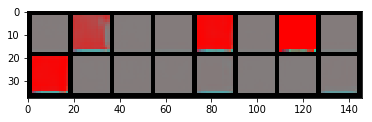

In [ ]:
ep = 0
netG.train()

start_t = time.time()
for count in range(1, max_count):
    ims, mks = prepare_data(batch_size)

    noise = Variable(torch.FloatTensor(batch_size, nz))
    noise.data.normal_(0, 1)
    fake_ims = netG(noise)
    
    # train D    
    netD.zero_grad()
    real_logits = netD(ims, mks)
    fake_logits = netD(fake_ims.detach())
    fake_labels = torch.zeros_like(fake_logits)
    real_labels = torch.ones_like(real_logits)
    errD_real = criterion_one(real_logits, real_labels) # Real/Fake loss for the real image
    errD_fake = criterion_one(fake_logits, fake_labels) # Real/Fake loss for the fake image
    errD = errD_real + errD_fake
    errD.backward()
    optD.step()
    
    # train G
    netG.zero_grad()
    netD.zero_grad()
    fake_logits = netD(fake_ims)
    real_labels = torch.ones_like(fake_logits)
    errG = criterion_one(fake_logits, real_labels)
    errG.backward()
    optG.step()
    
    if count % 1000 == 0:
        ep += 1
        end_t = time.time()
        print('[%d/%d]Loss_D: %.2f Loss_G: %.2f Time: %.2fs'
              % (ep, int(max_count/1000),
                 errD.item(), errG.item(),
                 end_t - start_t))
        imshow(fake_ims)
        start_t = time.time()

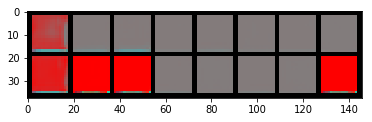

In [ ]:
netG.eval()
_noise = Variable(torch.FloatTensor(16, nz))
_noise.data.normal_(0, 1)
imshow(netG(_noise))